# The Weather Sensory Data Prediction based on LSTM
2011-13330 SNU CLS Seokmo-Yoo \\



1. Load prepared data from Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
dir_path = 'snu2020-thesis'

%cd drive/My\ Drive
%cp -r $dir_path ../../
%cd ../..
%cd $dir_path

Mounted at /content/drive
/content/drive/My Drive
/content
/content/snu2020-thesis


2. Train the model

In [53]:
#-*- coding:utf-8 -*-
# 2011-13330 SNU CLS Seokmo-Yoo
# Graduation Thesis
# The Weather Sensory Data Prediction based on LSTM
import numpy as np
import matplotlib.pyplot as plt   
import pandas as pd
from scipy.signal import medfilt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, r2_score

# define functions
# normalize data
def normalize(data):
  res = np.zeros(data.shape)
  row, col = data.shape
  maxs = np.copy(data[0])
  mins = np.copy(data[0])
  scales = np.zeros(col)
  # find min and max
  for i in range(0, row):
    for j in range(0, col):
      if (maxs[j] < data[i, j]): maxs[j] = data[i, j]
      if (mins[j] > data[i, j]): mins[j] = data[i, j]
  # calculate scales
  for j in range(0, col): scales[j] = maxs[j] - mins[j]
  # normalize
  for i in range(0, row):
    for j in range(0, col):
        res[i, j] = (data[i, j] - mins[j]) / scales[j]
        res[i, j] = 2.0 * res[i, j] - 1.0 # range -1 ~ 1
  return res, mins, scales

# denormalize data
def denormalize(data, mins, scales):
  res = np.zeros(data.shape)
  if (len(data.shape) == 2):
    row, col = data.shape
    # denormalize
    for i in range(0, row):
      for j in range(0, col):
          res[i, j] = 0.5 * (data[i, j] + 1.0) # range 0 ~ 1
          res[i, j] = res[i, j] * scales[j] + mins[j]
  elif (len(data.shape) == 1):
    col = data.shape[0]
    # denormalize
    for j in range(0, col):
        res[j] = 0.5 * (data[j] + 1.0) # range 0 ~ 1
        res[j] = res[j] * scales[j] + mins[j]
  else:
    return data
  return res

# split data by window
def split_data(data, window_size):
    X = np.zeros((len(data) - window_size, window_size, 1))
    y = np.zeros((len(data) - window_size, 1))
    for i in range(0, len(data) - window_size):
        partial_x = data[i:i + window_size].reshape((-1, 1)) # window_size-1 of data
        partial_y = data[i + window_size].reshape((-1)) # 1 of data
        X[i], y[i] = partial_x, partial_y
    return X, y

# create a figure and an ax
def add_figure(figs, axes):
  figs += [plt.figure(figsize=(8,6))]
  axes += [figs[len(figs)-1].add_subplot()]
  fig = figs[len(figs)-1]
  ax = axes[len(axes)-1]
  return figs, axes, fig, ax

# set up data path and training constants
#data_path = "data/OBS_ASOS_DD_19040409-20200609.csv"
data_path = "/content/snu2020-thesis/data/OBS_ASOS_DD_19040409-20200609.csv"
train_ratio = 0.5 # ratio of training
window_size = 30 # sliding window size(day)
num_epochs = 10 # number of epoches

# read data and preparation
data_raw = pd.read_csv(data_path) # read csv raw data
data_raw = data_raw.fillna(0) # fill NaN 0
#data_raw = data_raw.iloc[:,1:2] # use only AvgTemp
data_raw = data_raw.iloc[:,2:3] # use only LowTemp
#data_raw = data_raw.iloc[:,3:4] # use only HighTemp
#data_raw = data_raw.iloc[:,4:5] # use only Precipitation
data_raw = data_raw.to_numpy() # convert to numpy
data = medfilt(data_raw.reshape((-1)), 3).reshape((-1,1)) # smoothing by median filter
data, mins, scales = normalize(data) # normalize

# split training and test data
train_set = data[0:int(data.shape[0] * (1-train_ratio)),:]
train_set_raw = data_raw[0:int(data.shape[0] * (1-train_ratio)),:]
test_set = data[int(data.shape[0] * (1-train_ratio)):data.shape[0],:]
test_set_raw = data_raw[int(data.shape[0] * (1-train_ratio)):data.shape[0],:]

# split data into window size
X_train, y_train = split_data(train_set, window_size)
X_train_raw, y_train_raw = split_data(train_set_raw, window_size)
X_test, y_test = split_data(test_set, window_size)
X_test_raw, y_test_raw = split_data(test_set_raw, window_size)

# LSTM model
model = models.Sequential([
    layers.LSTM(units=100, return_sequences=False, dtype=tf.float32, input_shape=(window_size, 1)),
    layers.Dense(units=1, activation=None)
  ])
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
result = model.fit(X_train, y_train, epochs=num_epochs, batch_size=128)
loss = result.history['loss']

Epoch 1/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0200
Epoch 2/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0112
Epoch 3/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0072
Epoch 4/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0050
Epoch 5/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 6/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0045
Epoch 7/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0044
Epoch 8/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 9/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0043
Epoch 10/10
155/155 [==============================] - 1s 4ms/step - loss: 0.0043


3. Predict and analysis

MSE: 3.488715
R_squared: 0.968319


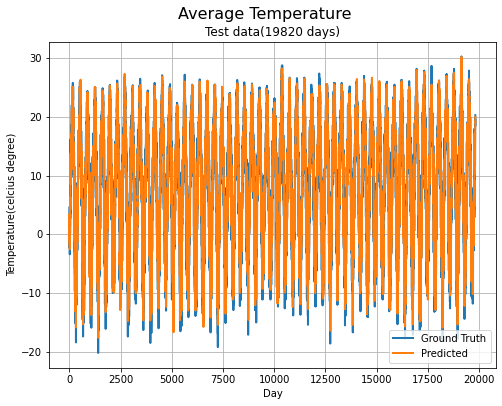

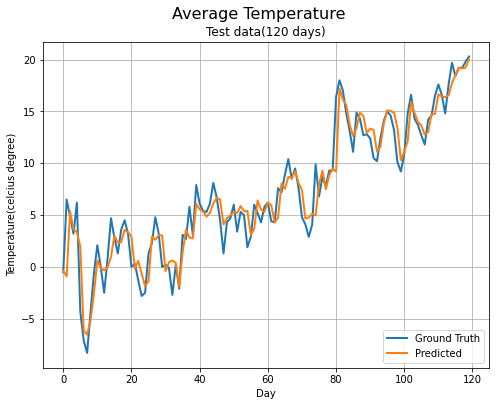

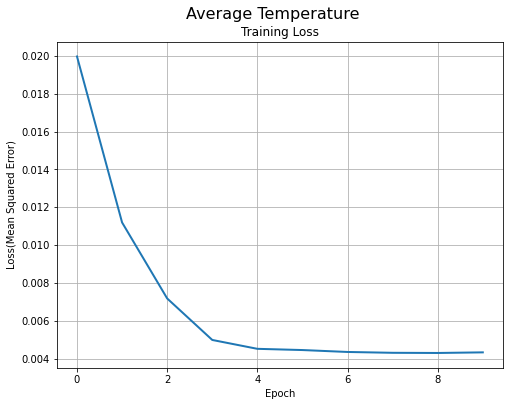

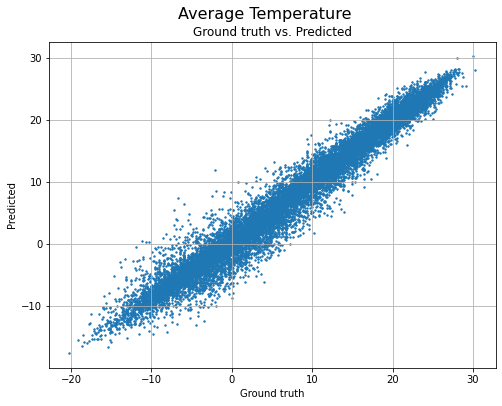

In [59]:
# prediction
y_pred = model.predict(X_test)
# denormalize data
y_pred_final = denormalize(y_pred, mins, scales).reshape((-1))
y_train_final = denormalize(y_train, mins, scales).reshape((-1))
y_test_final = denormalize(y_test, mins, scales).reshape((-1))

# MSE and R squared information
MSE = mean_squared_error(y_test_raw, y_pred_final)
R_squared = r2_score(y_test_raw, y_pred_final)
print("MSE: %.6f" % MSE)
print("R_squared: %.6f" % R_squared)

# draw figures
sup_title = "Average Temperature"
figs, axes, fig, ax = add_figure([], [])
fig.suptitle(sup_title, fontsize=16, y=0.96)
ax.set_title("Test data(%d days)" % (y_test.shape[0]))
ax.grid(True)
ax.plot(y_test_raw, linewidth=2,label='Ground Truth')
ax.plot(y_pred_final, linewidth=2, label='Predicted')
ax.legend(loc='lower right')
ax.set_xlabel("Day")
ax.set_ylabel("Temperature(celcius degree)")


figs, axes, fig, ax = add_figure(figs, axes)
fig.suptitle(sup_title, fontsize=16, y=0.96)
ax.set_title("Test data(%d days)" % (120))
ax.grid(True)
ax.plot(y_test_raw[-120:], linewidth=2, label='Ground Truth')
ax.plot(y_pred_final[-120:], linewidth=2, label='Predicted')
ax.legend(loc='lower right')
ax.set_xlabel("Day")
ax.set_ylabel("Temperature(celcius degree)")


figs, axes, fig, ax = add_figure(figs, axes)
fig.suptitle(sup_title, fontsize=16, y=0.96)
ax.set_title("Training Loss")
ax.grid(True)
ax.plot(range(num_epochs), loss, linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss(Mean Squared Error)")


figs, axes, fig, ax = add_figure(figs, axes)
fig.suptitle(sup_title, fontsize=16, y=0.96)
ax.set_title("Ground truth vs. Predicted")
ax.grid(True)
ax.scatter(y_test_raw, y_pred_final, s=2)
ax.set_xlabel("Ground truth")
ax.set_ylabel("Predicted")

plt.show()

Appendix. The parameters of the model

In [57]:
[list(i.shape) for i in model.weights]

[[1, 400], [100, 400], [400], [100, 1], [1]]